In [1]:
import pandas as pd
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import numpy as np
from fairlearn.datasets import fetch_acs_income
import shap

from scipy.spatial.distance import cosine, euclidean
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score

import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBRegressor, XGBClassifier #continuous values?


## Binary classification

### Data Analysis

In [2]:
data = fetch_acs_income()
# convert to df
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
 # I'm not sure what this feature even is cause I can't  find anything about it in the documenation so I'm leaving it oout for now
df = df.drop(columns=['ST'], errors='ignore')

print(df.head())

   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P   target
0  18.0  1.0  18.0  5.0  4720.0  13.0  17.0  21.0  2.0    2.0   1600.0
1  53.0  5.0  17.0  5.0  3605.0  18.0  16.0  40.0  1.0    1.0  10000.0
2  41.0  1.0  16.0  5.0  7330.0   1.0  17.0  40.0  1.0    1.0  24000.0
3  18.0  6.0  18.0  5.0  2722.0   1.0  17.0   2.0  2.0    1.0    180.0
4  21.0  5.0  19.0  5.0  3870.0  12.0  17.0  50.0  1.0    1.0  29000.0


In [ ]:
df.isna().sum()

AGEP      0
COW       0
SCHL      0
MAR       0
OCCP      0
POBP      0
RELP      0
WKHP      0
SEX       0
RAC1P     0
target    0
dtype: int64

In [ ]:
df['OCCP'].value_counts().sort_index()


OCCP
10.0      14296
20.0      10186
40.0        563
51.0       5548
52.0       4601
          ...  
9760.0      803
9800.0      413
9810.0      794
9825.0     1993
9830.0     2504
Name: count, Length: 529, dtype: int64

In [3]:
numeric_cols = ['AGEP', 'WKHP']
categorical_cols = ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX',  'RAC1P'] 

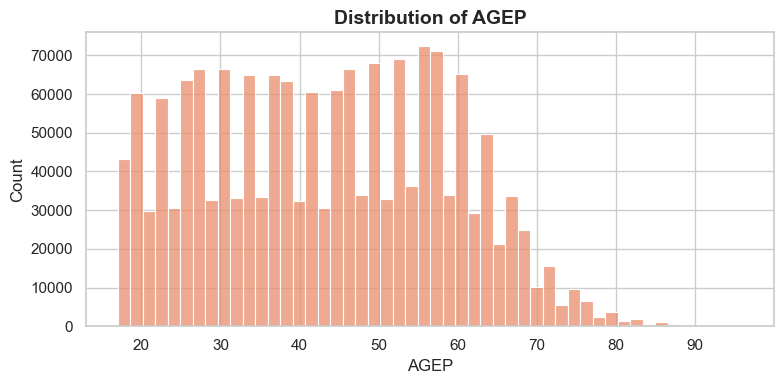

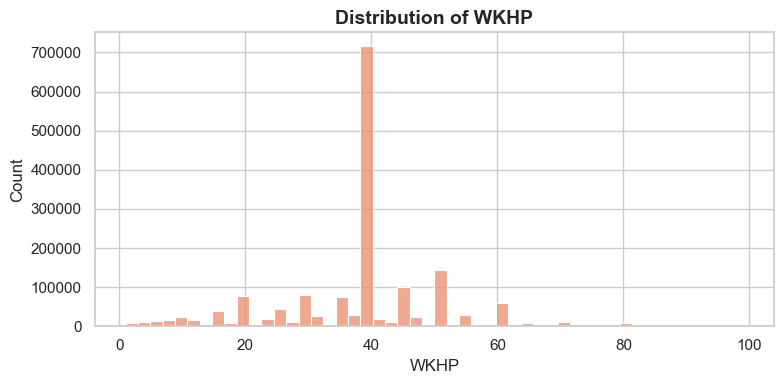

In [4]:

sns.set_theme(style="whitegrid", palette="flare")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=False, color=sns.color_palette("flare")[0])
    plt.title(f'Distribution of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


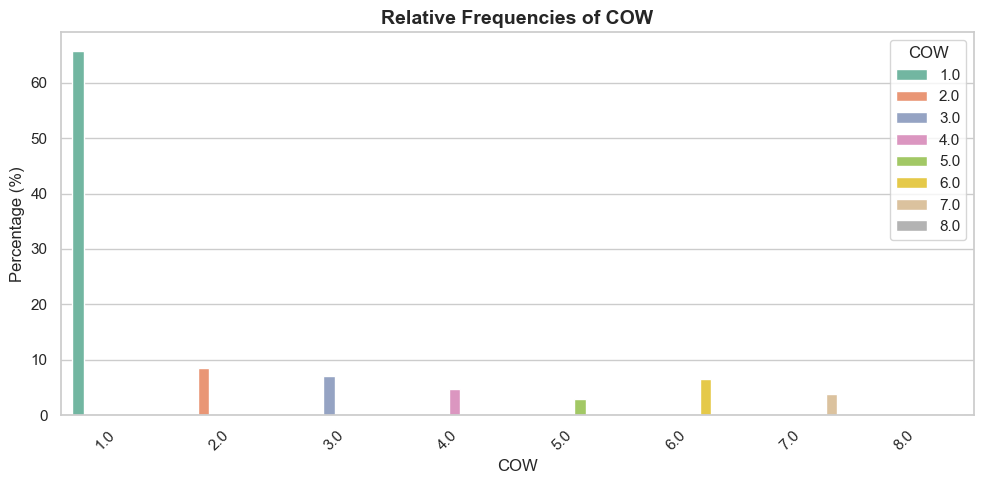

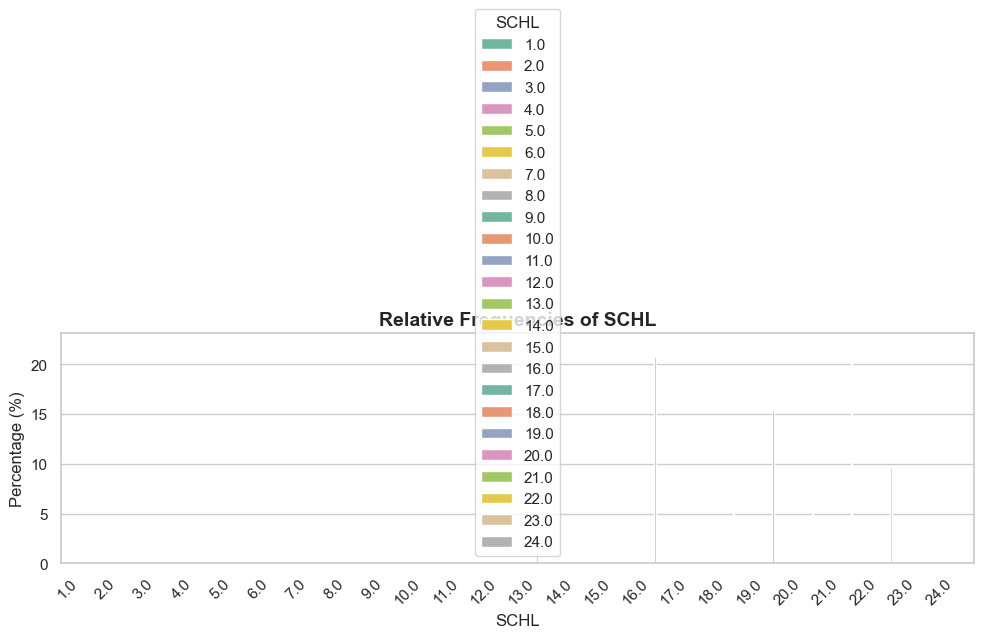

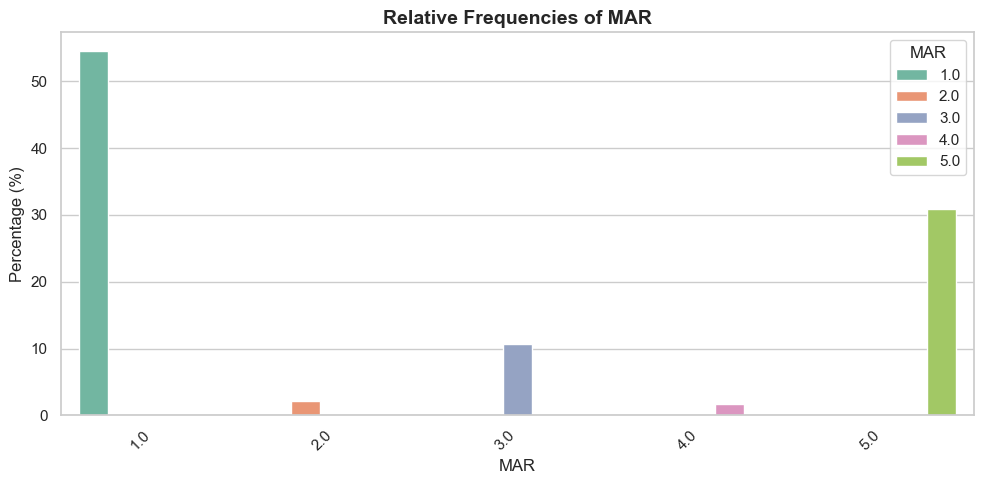

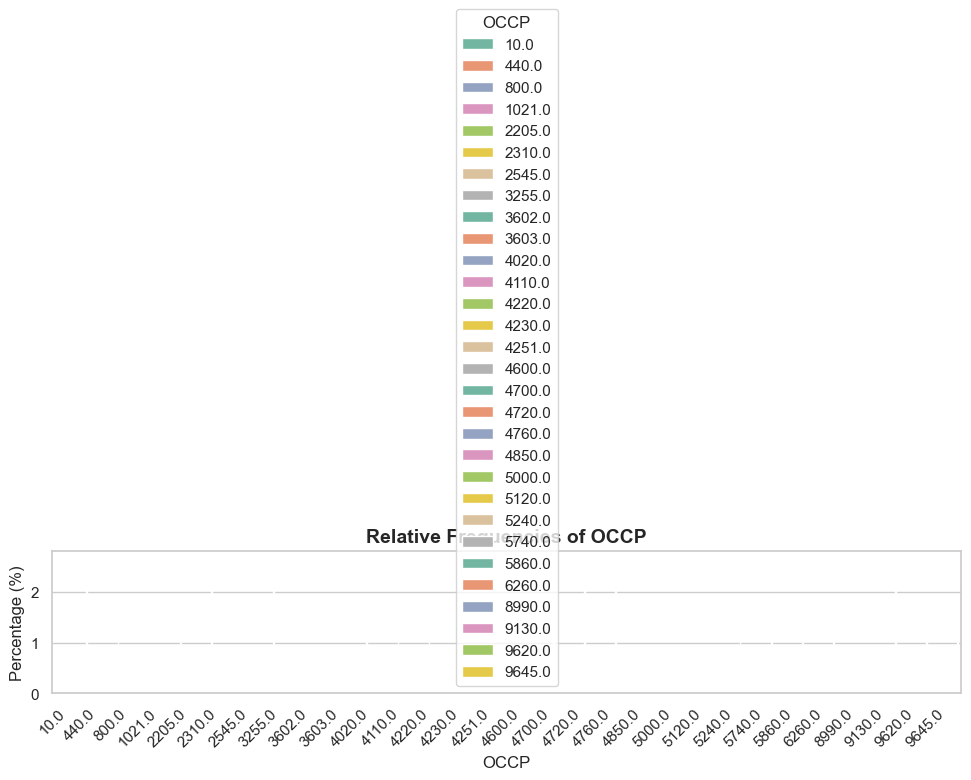

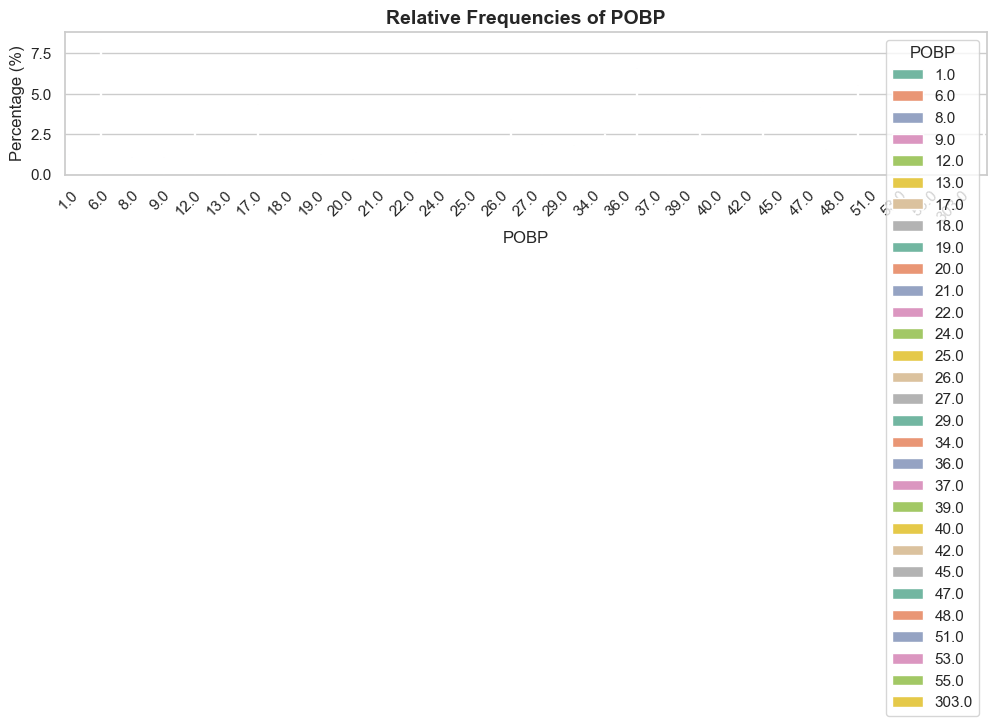

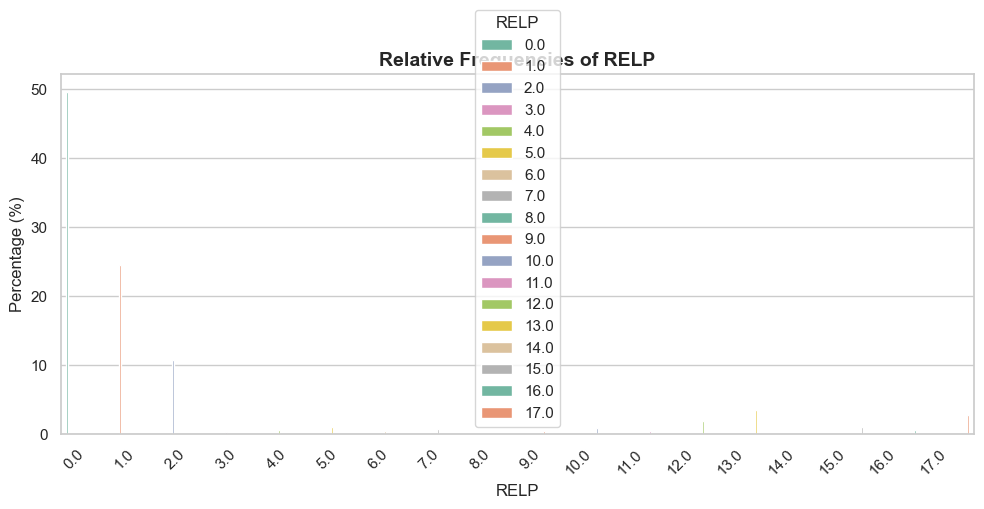

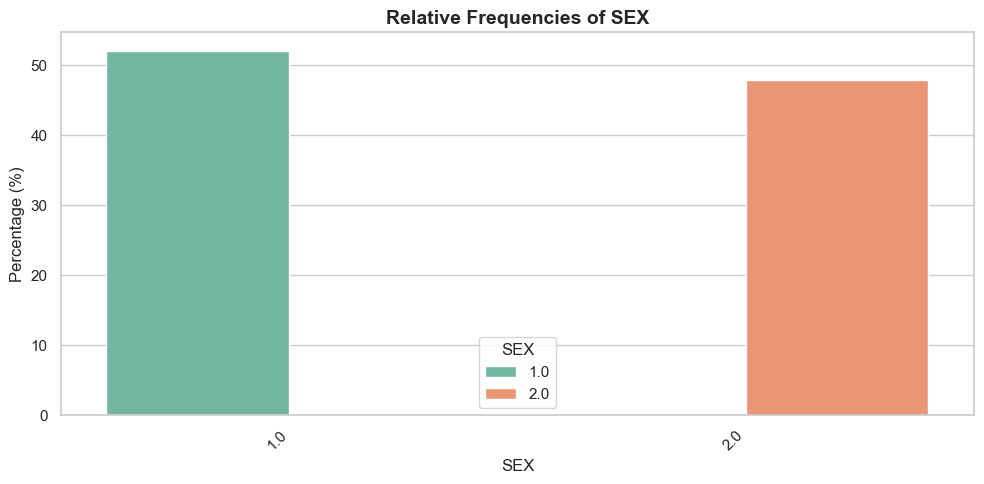

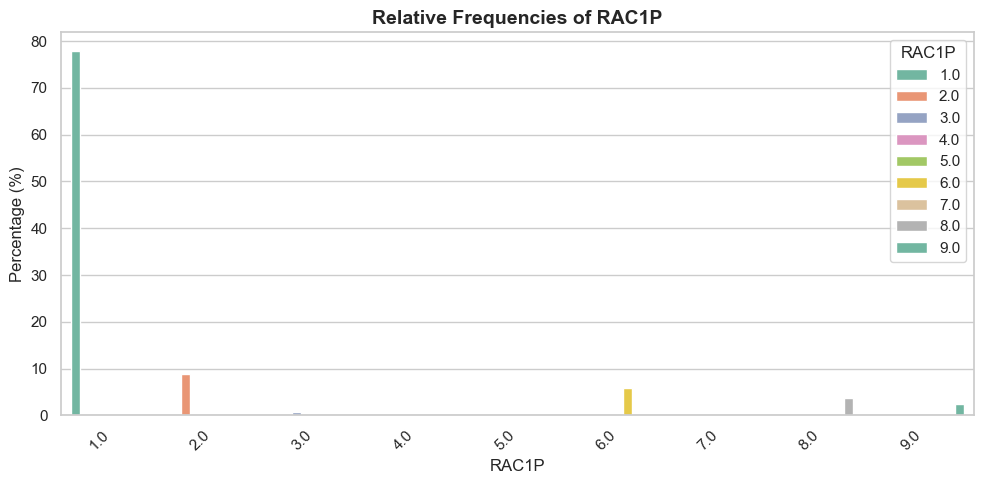

In [6]:
sns.set_theme(style="whitegrid", palette="Set2")

limit_top_n = 30
columns_to_limit = ['OCCP', 'POBP'] 


for col in categorical_cols:
    plt.figure(figsize=(10, 5))

    # value counts normalized
    value_counts = df[col].value_counts(normalize=True) * 100
    
    if col in columns_to_limit:
        value_counts = value_counts.head(limit_top_n)

    plot_df = value_counts.reset_index()
    plot_df.columns = [col, 'percentage']

    sns.barplot(data=plot_df, x=col, y='percentage', hue=col, palette="Set2")
    
    plt.title(f'Relative Frequencies of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Pre-processing

In [ ]:
# potential approaches #
# Age clustering
# removing certain subgroups from OCCP, POBP

### Creating thresholds and splitting datasets

In [7]:

def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    return X, y


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(df, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor.fit(X_train)

X_train_enc = preprocessor.transform(X_train)
X_val_enc   = preprocessor.transform(X_val)
X_test_enc  = preprocessor.transform(X_test)


In [21]:
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

all_feature_names = list(ohe_feature_names) + numeric_cols

### Linear baseline model for performance comparison 
### **DO NOT RUN takes ages**

In [9]:
logreg = LogisticRegression(solver= 'saga', class_weight='balanced', max_iter=2500)
logreg.fit(X_train_enc, y_train)
y_pred_logreg = logreg.predict(X_test_enc)
print(classification_report(y_test, y_pred_logreg))


              precision    recall  f1-score   support

           0       0.87      0.79      0.83    151206
           1       0.72      0.82      0.77     98469

    accuracy                           0.80    249675
   macro avg       0.79      0.81      0.80    249675
weighted avg       0.81      0.80      0.80    249675



### **XGBoostClassifier** - Hyperparameter tuning with random grid search

In [10]:
param_dist = {
    'n_estimators': randint(100, 700),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

n_iter = 20
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))
results = []

for i, params in enumerate(param_list):
    print(f"\n Running trial {i+1}/{n_iter}...")
    print("Params:", params)
    start = time.time()

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        **params
    )

    model.fit(X_train_enc, y_train)
    y_val_pred = model.predict(X_val_enc)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    duration = time.time() - start
    print(f"Finished trial {i+1}/{n_iter} — Val F1 (macro): {val_f1:.4f} — Time: {duration:.1f}s")

    results.append((params, val_f1))

# Get best model
best_params, best_score = max(results, key=lambda x: x[1])
print("\nBest Hyperparameters:", best_params)
print(f"Best Validation F1 (macro): {best_score:.4f}")

# Train best model on full training data
best_model = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **best_params
)
best_model.fit(X_train_enc, y_train)

# Final test evaluation
y_test_pred = best_model.predict(X_test_enc)
print("\n Final Test Set Performance:")
print(classification_report(y_test, y_test_pred))




 Running trial 1/20...
Params: {'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(4.75357153204958), 'learning_rate': np.float64(0.22959818254342154), 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': np.float64(0.15599452033620265), 'reg_lambda': np.float64(0.05808361216819946), 'subsample': np.float64(0.9330880728874675)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 1/20 — Val F1 (macro): 0.8042 — Time: 12.4s

 Running trial 2/20...
Params: {'colsample_bytree': np.float64(0.8005575058716043), 'gamma': np.float64(3.540362888980227), 'learning_rate': np.float64(0.016175348288740735), 'max_depth': 4, 'n_estimators': 443, 'reg_alpha': np.float64(0.8324426408004217), 'reg_lambda': np.float64(0.21233911067827616), 'subsample': np.float64(0.5909124836035503)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 2/20 — Val F1 (macro): 0.7744 — Time: 23.6s

 Running trial 3/20...
Params: {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_depth': 14, 'n_estimators': 660, 'reg_alpha': np.float64(0.5247746602583891), 'reg_lambda': np.float64(0.3998609717152555), 'subsample': np.float64(0.5233328316068078)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 3/20 — Val F1 (macro): 0.8087 — Time: 55.2s

 Running trial 4/20...
Params: {'colsample_bytree': np.float64(0.9868777594207296), 'gamma': np.float64(1.1638567021515211), 'learning_rate': np.float64(0.03718193035984624), 'max_depth': 5, 'n_estimators': 666, 'reg_alpha': np.float64(0.9832308858067882), 'reg_lambda': np.float64(0.4667628932479799), 'subsample': np.float64(0.9299702033681603)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 4/20 — Val F1 (macro): 0.7939 — Time: 31.3s

 Running trial 5/20...
Params: {'colsample_bytree': np.float64(0.8401537692938899), 'gamma': np.float64(2.2524962598477147), 'learning_rate': np.float64(0.013979488347959958), 'max_depth': 11, 'n_estimators': 415, 'reg_alpha': np.float64(0.5632882178455393), 'reg_lambda': np.float64(0.3854165025399161), 'subsample': np.float64(0.5079831261101071)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 5/20 — Val F1 (macro): 0.7923 — Time: 43.5s

 Running trial 6/20...
Params: {'colsample_bytree': np.float64(0.6154469128110744), 'gamma': np.float64(1.2051273301300585), 'learning_rate': np.float64(0.21497905564763747), 'max_depth': 14, 'n_estimators': 608, 'reg_alpha': np.float64(0.8331949117361643), 'reg_lambda': np.float64(0.17336465350777208), 'subsample': np.float64(0.6955303037866204)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 6/20 — Val F1 (macro): 0.8081 — Time: 49.7s

 Running trial 7/20...
Params: {'colsample_bytree': np.float64(0.5911180438940311), 'gamma': np.float64(3.7768070515882624), 'learning_rate': np.float64(0.13754676234737342), 'max_depth': 8, 'n_estimators': 205, 'reg_alpha': np.float64(0.5677003278199915), 'reg_lambda': np.float64(0.03131329245555858), 'subsample': np.float64(0.9211423872974993)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 7/20 — Val F1 (macro): 0.8012 — Time: 12.2s

 Running trial 8/20...
Params: {'colsample_bytree': np.float64(0.7248770666848828), 'gamma': np.float64(1.9757511800090721), 'learning_rate': np.float64(0.28799765973813823), 'max_depth': 10, 'n_estimators': 561, 'reg_alpha': np.float64(0.1959828624191452), 'reg_lambda': np.float64(0.045227288910538066), 'subsample': np.float64(0.6626651653816322)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:30:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 8/20 — Val F1 (macro): 0.8066 — Time: 35.5s

 Running trial 9/20...
Params: {'colsample_bytree': np.float64(0.6943386448447411), 'gamma': np.float64(1.3567451588694794), 'learning_rate': np.float64(0.2586212527455788), 'max_depth': 12, 'n_estimators': 316, 'reg_alpha': np.float64(0.28093450968738076), 'reg_lambda': np.float64(0.5426960831582485), 'subsample': np.float64(0.5704621124873813)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 9/20 — Val F1 (macro): 0.8081 — Time: 22.6s

 Running trial 10/20...
Params: {'colsample_bytree': np.float64(0.9010984903770198), 'gamma': np.float64(0.3727532183988541), 'learning_rate': np.float64(0.3060660809801552), 'max_depth': 10, 'n_estimators': 228, 'reg_alpha': np.float64(0.1987156815341724), 'reg_lambda': np.float64(0.005522117123602399), 'subsample': np.float64(0.9077307142274171)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 10/20 — Val F1 (macro): 0.8058 — Time: 15.3s

 Running trial 11/20...
Params: {'colsample_bytree': np.float64(0.8534286719238086), 'gamma': np.float64(3.6450358402049368), 'learning_rate': np.float64(0.24138110400578372), 'max_depth': 7, 'n_estimators': 589, 'reg_alpha': np.float64(0.3584657285442726), 'reg_lambda': np.float64(0.11586905952512971), 'subsample': np.float64(0.9315517129377968)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 11/20 — Val F1 (macro): 0.8075 — Time: 29.7s

 Running trial 12/20...
Params: {'colsample_bytree': np.float64(0.811649063413779), 'gamma': np.float64(1.654490124263246), 'learning_rate': np.float64(0.02906750508580709), 'max_depth': 9, 'n_estimators': 673, 'reg_alpha': np.float64(0.32518332202674705), 'reg_lambda': np.float64(0.7296061783380641), 'subsample': np.float64(0.8187787356776066)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:31:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 12/20 — Val F1 (macro): 0.7999 — Time: 52.1s

 Running trial 13/20...
Params: {'colsample_bytree': np.float64(0.9436063712881633), 'gamma': np.float64(2.3610746258097466), 'learning_rate': np.float64(0.04587827378149051), 'max_depth': 5, 'n_estimators': 104, 'reg_alpha': np.float64(0.5612771975694962), 'reg_lambda': np.float64(0.770967179954561), 'subsample': np.float64(0.7468977981821954)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 13/20 — Val F1 (macro): 0.7731 — Time: 8.1s

 Running trial 14/20...
Params: {'colsample_bytree': np.float64(0.7613664146909971), 'gamma': np.float64(2.137705091792748), 'learning_rate': np.float64(0.017625738023228556), 'max_depth': 5, 'n_estimators': 674, 'reg_alpha': np.float64(0.8957635956735194), 'reg_lambda': np.float64(0.47537022318211175), 'subsample': np.float64(0.7816377859881918)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 14/20 — Val F1 (macro): 0.7859 — Time: 39.1s

 Running trial 15/20...
Params: {'colsample_bytree': np.float64(0.8477580432130638), 'gamma': np.float64(0.6966572720293784), 'learning_rate': np.float64(0.1913252137833452), 'max_depth': 13, 'n_estimators': 640, 'reg_alpha': np.float64(0.22879816549162246), 'reg_lambda': np.float64(0.07697990982879299), 'subsample': np.float64(0.6448757264568841)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:33:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 15/20 — Val F1 (macro): 0.8064 — Time: 54.0s

 Running trial 16/20...
Params: {'colsample_bytree': np.float64(0.5806106436270022), 'gamma': np.float64(4.648488261712865), 'learning_rate': np.float64(0.2524361138693251), 'max_depth': 11, 'n_estimators': 127, 'reg_alpha': np.float64(0.2184404372168336), 'reg_lambda': np.float64(0.4165099478703662), 'subsample': np.float64(0.9416401294594341)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 16/20 — Val F1 (macro): 0.8039 — Time: 10.5s

 Running trial 17/20...
Params: {'colsample_bytree': np.float64(0.662172510502637), 'gamma': np.float64(0.6104397735033668), 'learning_rate': np.float64(0.11688935142309247), 'max_depth': 3, 'n_estimators': 484, 'reg_alpha': np.float64(0.22793516254194168), 'reg_lambda': np.float64(0.4271077886262563), 'subsample': np.float64(0.9090073829612466)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:34:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 17/20 — Val F1 (macro): 0.7957 — Time: 23.7s

 Running trial 18/20...
Params: {'colsample_bytree': np.float64(0.9303652916281717), 'gamma': np.float64(0.03476065265595352), 'learning_rate': np.float64(0.16322419077326972), 'max_depth': 11, 'n_estimators': 417, 'reg_alpha': np.float64(0.22210781047073025), 'reg_lambda': np.float64(0.1198653673336828), 'subsample': np.float64(0.668807585701814)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 18/20 — Val F1 (macro): 0.8070 — Time: 36.0s

 Running trial 19/20...
Params: {'colsample_bytree': np.float64(0.9714548519562596), 'gamma': np.float64(1.6160146601037761), 'learning_rate': np.float64(0.16563718652300982), 'max_depth': 11, 'n_estimators': 212, 'reg_alpha': np.float64(0.06489224710898156), 'reg_lambda': np.float64(0.2539154139343447), 'subsample': np.float64(0.6234380314193007)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 19/20 — Val F1 (macro): 0.8057 — Time: 18.2s

 Running trial 20/20...
Params: {'colsample_bytree': np.float64(0.8481521364198942), 'gamma': np.float64(3.56135294962221), 'learning_rate': np.float64(0.05442607898601997), 'max_depth': 10, 'n_estimators': 180, 'reg_alpha': np.float64(0.266781014275285), 'reg_lambda': np.float64(0.9766149558326529), 'subsample': np.float64(0.7055185066591156)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 20/20 — Val F1 (macro): 0.7954 — Time: 16.8s

Best Hyperparameters: {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_depth': 14, 'n_estimators': 660, 'reg_alpha': np.float64(0.5247746602583891), 'reg_lambda': np.float64(0.3998609717152555), 'subsample': np.float64(0.5233328316068078)}
Best Validation F1 (macro): 0.8087

 Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85    151206
           1       0.78      0.76      0.77     98469

    accuracy                           0.82    249675
   macro avg       0.81      0.81      0.81    249675
weighted avg       0.82      0.82      0.82    249675



### TreeSHAP

In [22]:
# run ONLY IF you didn't run the previous code block

best_params = {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_depth': 14, 'n_estimators': 660, 'reg_alpha': np.float64(0.5247746602583891), 'reg_lambda': np.float64(0.3998609717152555), 'subsample': np.float64(0.5233328316068078)}

best_model = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **best_params
)
best_model.fit(X_train_enc, y_train)

explainer = shap.Explainer(best_model, feature_names = all_feature_names)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5917022549267169, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=1.5212112147976886, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16742692948967136,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=660, n_jobs=-1,
              num_parallel_tree=None, ...)

In [76]:
def rename_features(shap_values):
    custom_names = {
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1.0': 'Male',
    'SEX_2.0': 'Female',
    'RELP_0.0': 'Householder',
    'SCHL_21.0': 'Bachelors Degree',
    'SCHL_22.0': 'Masters Degree',
    'SCHL_23.0': 'Professional degree beyond a bachelos degree',
    'MAR_1.0': 'Married',
    'MAR_5.0': 'Never Married',
    'OCCP_3255.0': 'Occupation: Registered Nurse',
    'RELP_1.0': 'Husband/Wife of Householder',
    'RAC1P_2.0': 'Black or African American alone',
    'RAC1P_1.0': 'White alone'
    }
    renamed_features = [
        custom_names.get(name, name)
        for name in shap_values.feature_names
    ]
    return renamed_features

### White-only SHAP

In [47]:
white_index = all_feature_names.index('RAC1P_1.0')
white_column = X_test_enc[:, white_index].toarray().ravel()
white_mask = white_column == 1.0
white_alone = X_test_enc[white_mask]

shap_values = explainer(white_alone)

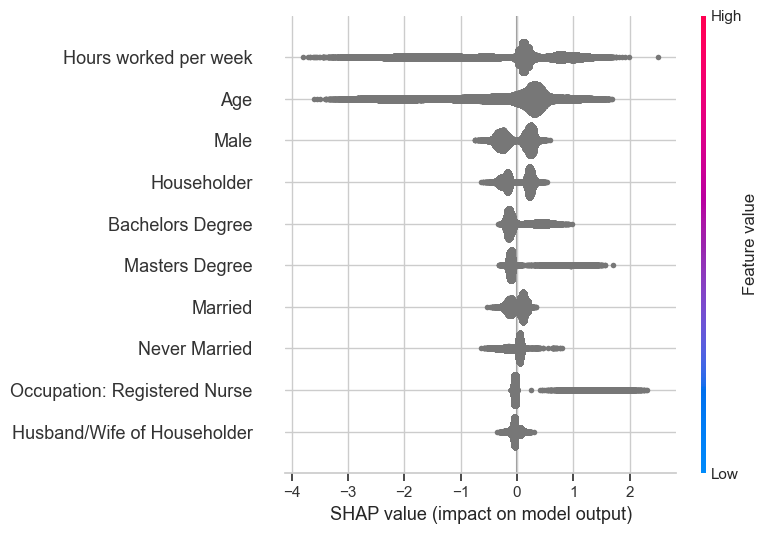

In [64]:
shap.summary_plot(shap_values, white_alone, max_display=10)

### Black-only SHAP

In [51]:
black_index = all_feature_names.index('RAC1P_2.0')
black_column = X_test_enc[:, black_index].toarray().ravel()
black_mask = black_column == 1.0
black_or_afam_alone = X_test_enc[black_mask]

In [52]:
black_shap_values = explainer(black_or_afam_alone)

In [69]:
black_shap_values.feature_names = rename_features(black_shap_values)

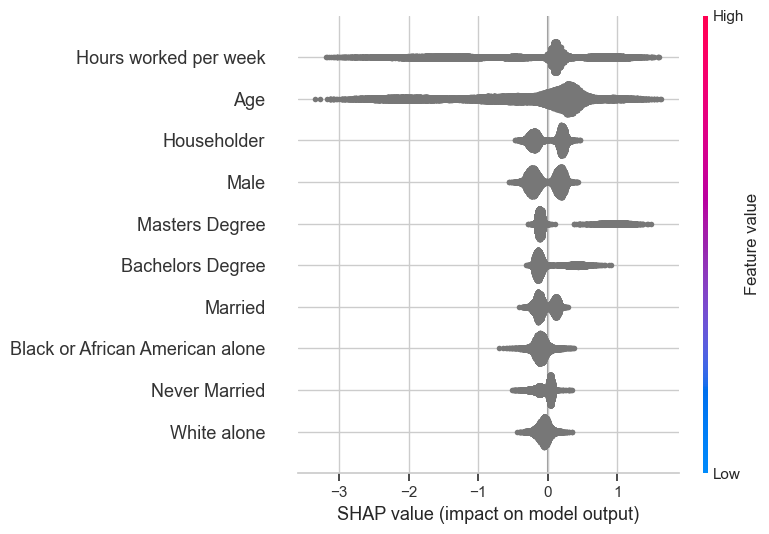

In [70]:
shap.summary_plot(black_shap_values, black_or_afam_alone, max_display=10)

### Female SHAP

In [56]:
female_index = all_feature_names.index('SEX_2.0')
female_column = X_test_enc[:, female_index].toarray().ravel()
female_mask = female_column == 1.0
female_X_enc = X_test_enc[female_mask]

In [57]:
female_shap_values = explainer(female_X_enc)

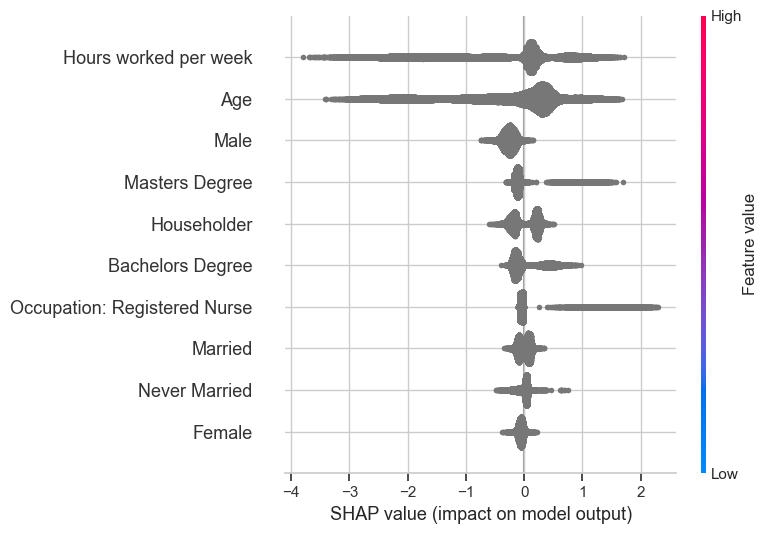

In [73]:
female_shap_values.feature_names = rename_features(female_shap_values)
shap.summary_plot(female_shap_values, female_X_enc, max_display=10)

### Male Only SHAP

In [59]:
male_index = all_feature_names.index('SEX_1.0')
male_column = X_test_enc[:, male_index].toarray().ravel()
male_mask = male_column == 1.0
male_X_enc = X_test_enc[male_mask]

male_shap_values = explainer(male_X_enc)

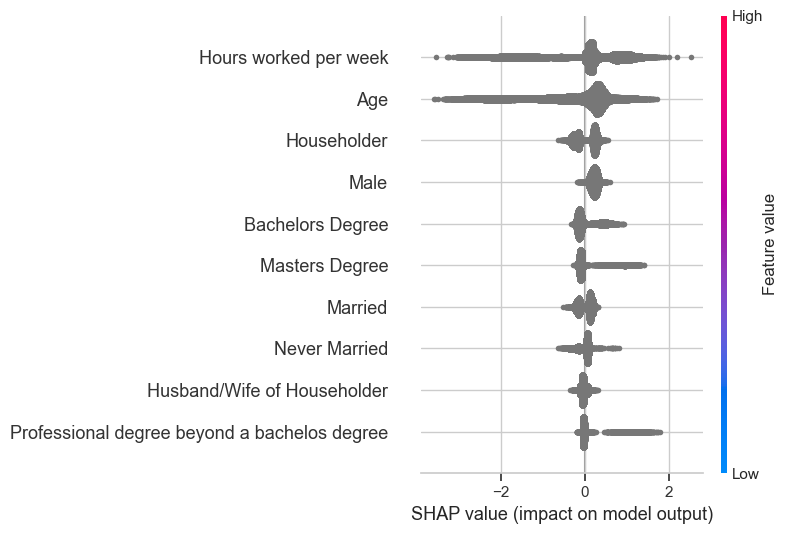

In [77]:
male_shap_values.feature_names = rename_features(male_shap_values)
shap.summary_plot(male_shap_values, male_X_enc, max_display=10)

## All population SHAP

In [35]:
shap_values = explainer(X_test_enc)
shap_values.feature_names = rename_features(shap_values)

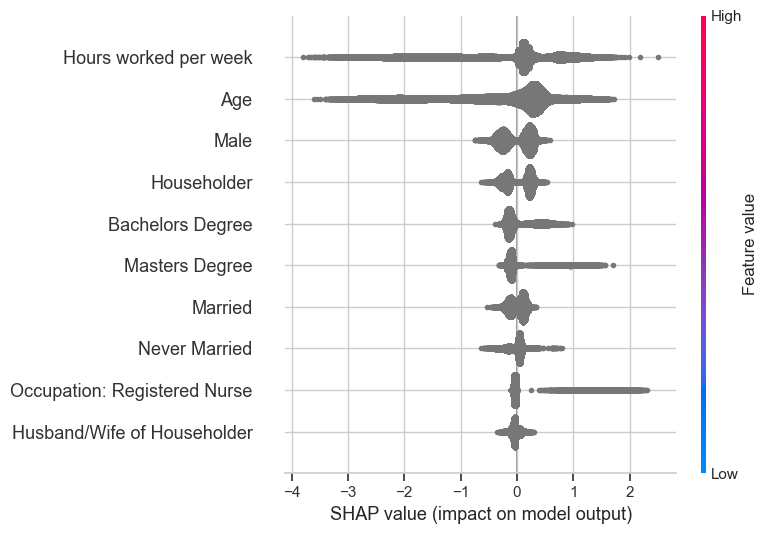

In [36]:
shap.summary_plot(shap_values, X_test_enc, max_display=10)

# T-test

In [27]:
from scipy.stats import ttest_ind

# example: male v female cauacasian
mask_A = (X_test['SEX'] == 1) & (X_test['RAC1P'] == 1)
mask_B = (X_test['SEX'] == 2) & (X_test['RAC1P'] == 1)

shap_male = shap_values.values[mask_A.values]
shap_female = shap_values.values[mask_B.values]
feature_names =[]
t_test_results = []

for i, feature in enumerate(feature_names):
    group1 = shap_male[:, i]
    group2 = shap_female[:, i]
    
    stat, pval = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test to account for variance differences
    t_test_results.append({
        'feature': feature,
        't_stat': stat,
        'p_value': pval,
        'mean_diff': group1.mean() - group2.mean()
    })

# Turn into a DataFrame
t_test_df = pd.DataFrame(t_test_results)

# Sort by p-value for significance
t_test_df = t_test_df.sort_values('p_value')

# Display top differences
print(t_test_df[['feature', 't_stat', 'p_value', 'mean_diff']].head(15))


KeyError: 'p_value'

### **Simple FFNN** - Hyperparameter tuning with random grid search


In [ ]:
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        Dense(hidden_units, input_dim=input_dim, activation='relu'),
        Dropout(dropout_rate),
        Dense(hidden_units // 2, activation='relu'),
        Dense(1, activation='sigmoid')  # binary output
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

param_dist = {
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.5, 0.7],
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

def sample_params(param_dist):
    return {k: np.random.choice(v) for k, v in param_dist.items()}

n_iter = 10
input_dim = X_train_enc.shape[1]
results = []

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)


for i in range(n_iter):
    params = sample_params(param_dist)
    print(f"Trial {i+1}/{n_iter} with params: {params}")

    model = build_ffnn(
        input_dim=input_dim,
        hidden_units=params['hidden_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

    model.fit(
        X_train_enc, y_train,
        validation_data=(X_val_enc, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0, 
        class_weight=dict(enumerate(class_weights))
    )

    val_preds = model.predict(X_val_enc).ravel()
    val_auc = roc_auc_score(y_val, val_preds)
    print(f"Val AUC: {val_auc:.4f}\n")

    results.append((params, val_auc))

# Find the best model
best_params, best_val_auc = max(results, key=lambda x: x[1])
print(f" Best Params: {best_params}\n🏆 Best Val AUC: {best_val_auc:.4f}")


In [ ]:
# build best model
best_model_NN = build_ffnn(
    input_dim=input_dim,
    hidden_units=best_params['hidden_units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model_NN.fit(
    X_train_enc, y_train,
    validation_data=(X_val_enc, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0,
    class_weight=dict(enumerate(class_weights))
)


In [ ]:

# sample representative background set
background_size = 10000

# stratified sample from training set
sss = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
background_idx, _ = next(sss.split(X_train_enc, y_train))

background = X_train_enc[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background

# get test data
X_test_array = X_test_enc.toarray() if hasattr(X_test_enc, "toarray") else X_test_enc

# DeepSHAP
explainer = shap.DeepExplainer(best_model, background)
shap_values = explainer.shap_values(X_test_array)[0]  # [0] for binary output

# df of SHAP values
shap_df = pd.DataFrame(shap_values, columns=feature_names)

In [ ]:
shap.summary_plot(shap_values, features=X_test_array, feature_names=feature_names)

# Continuous target variable

## XGBoost

In [2]:
data = fetch_acs_income()
# convert to df
df = pd.DataFrame(data.data, columns=data.feature_names)

# create target column
df['target'] = data.target
print(data.feature_names)
print(df.head())

['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P', 'ST']
   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P  ST   target
0  18.0  1.0  18.0  5.0  4720.0  13.0  17.0  21.0  2.0    2.0 NaN   1600.0
1  53.0  5.0  17.0  5.0  3605.0  18.0  16.0  40.0  1.0    1.0 NaN  10000.0
2  41.0  1.0  16.0  5.0  7330.0   1.0  17.0  40.0  1.0    1.0 NaN  24000.0
3  18.0  6.0  18.0  5.0  2722.0   1.0  17.0   2.0  2.0    1.0 NaN    180.0
4  21.0  5.0  19.0  5.0  3870.0  12.0  17.0  50.0  1.0    1.0 NaN  29000.0


In [14]:
# remove the 'ST' column
df = df.drop(columns=['ST', 'RELP'], errors='ignore')

# change 'MAR' values -> convert 2–5 to 0 (e.g., not married)
df['MAR'] = df['MAR'].apply(lambda x: 0 if x in [2, 3, 4, 5] else x)

# filter out individuals younger than 18
df = df[df['AGEP'] >= 18]

# keep rows where 'WKHP' is between 36 and 60 inclusive
df = df[(df['WKHP'] >= 30) & (df['WKHP'] <= 60)]

# reset index after filtering
df = df.reset_index(drop=True)

In [15]:
# mapping from numeric codes to race category names
race_labels = {
    1: "White alone",
    2: "Black or African American alone",
    3: "American Indian alone",
    4: "Alaska Native alone",
    5: "American Indian and Alaska Native tribes specified or not specified",
    6: "Asian alone",
    7: "Native Hawaiian and Other Pacific Islander alone",
    8: "Some Other Race alone",
    9: "Two or More races"
}

rac1p_counts = df['RAC1P'].value_counts().sort_index()
# calc length for alignment
max_label_len = max(len(label) for label in race_labels.values())

# match labels
print(f"{'Race Category'.ljust(max_label_len)} | Count")
print("-" * (max_label_len + 8))
for code, count in rac1p_counts.items():
    label = race_labels.get(code, f"Unknown ({code})")
    print(f"{label.ljust(max_label_len)} | {count}")

Race Category                                                       | Count
---------------------------------------------------------------------------
White alone                                                         | 1030553
Black or African American alone                                     | 117711
Asian alone                                                         | 77610
Two or More races                                                   | 31559


In [16]:
selected_codes = [1, 2, 6, 9]
subset_count = df['RAC1P'].isin(selected_codes).sum()
print(f"Total count for RAC1P categories {selected_codes}: {subset_count}")

Total count for RAC1P categories [1, 2, 6, 9]: 1257433


In [17]:
df = df[df['RAC1P'].isin(selected_codes)].reset_index(drop=True)

In [18]:
# mapping occupation codes to broader categories
def recode_occp(occp_code):
    if 10 <= occp_code <= 3550: # Management, Business, Science, and Arts Occupations
        return 1
    elif 3601 <= occp_code <= 4655: # "Service Occupations"
        return 2
    elif 4700 <= occp_code <= 5940: # "Sales and Office Occupations"
        return 3
    elif 6005 <= occp_code <= 7640: # "Natural Resources, Construction, and Maintenance Occupations"
        return 4
    elif 7700 <= occp_code <= 9760: # "Production, Transportation, and Material Moving Occupations"
        return 5
    elif 9800 <= occp_code <= 9830: # Military Specific Occupations
        return 6
    else:
        return 0 
    
df["OCCP_cat"] = df["OCCP"].apply(recode_occp)
df.drop(columns="OCCP")

,AGEP,SCHL,MAR,POBP,WKHP,SEX,RAC1P,target,OCCP_cat,SCHL_cat,Nativity
0,53.0,17.0,0.0,18.0,40.0,1.0,1.0,10000.0,2,2,1
1,41.0,16.0,0.0,1.0,40.0,1.0,1.0,24000.0,4,2,1
2,21.0,19.0,0.0,12.0,50.0,1.0,1.0,29000.0,2,2,1
3,37.0,16.0,0.0,1.0,35.0,1.0,2.0,24100.0,5,2,1
4,51.0,20.0,0.0,1.0,60.0,2.0,1.0,30000.0,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...
1257428,65.0,21.0,0.0,72.0,40.0,2.0,9.0,90000.0,1,4,0
1257429,43.0,21.0,0.0,72.0,40.0,1.0,9.0,17300.0,2,4,0
1257430,45.0,16.0,0.0,72.0,40.0,2.0,1.0,30000.0,2,2,0
1257431,37.0,19.0,0.0,17.0,40.0,2.0,9.0,19700.0,5,2,1


In [19]:
def recode_schl(schl_code):
    if schl_code <= 15: # No high school diploma
        return 1
    elif 15 <= schl_code <= 19: # High school diploma or equivalent
        return 2
    elif schl_code == 20: # Associate's degree
        return 3
    elif schl_code == 21: # Bachelor's degree
        return 4
    elif 22 <= schl_code <= 23: # Master's or professional degree
        return 5
    elif schl_code == 24: # Doctorate's degree
        return 6 
    
df["SCHL_cat"] = df["SCHL"].apply(recode_schl)
df.drop(columns="SCHL")

,AGEP,MAR,OCCP,POBP,WKHP,SEX,RAC1P,target,OCCP_cat,SCHL_cat,Nativity
0,53.0,0.0,3605.0,18.0,40.0,1.0,1.0,10000.0,2,2,1
1,41.0,0.0,7330.0,1.0,40.0,1.0,1.0,24000.0,4,2,1
2,21.0,0.0,3870.0,12.0,50.0,1.0,1.0,29000.0,2,2,1
3,37.0,0.0,9620.0,1.0,35.0,1.0,2.0,24100.0,5,2,1
4,51.0,0.0,5840.0,1.0,60.0,2.0,1.0,30000.0,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...
1257428,65.0,0.0,3050.0,72.0,40.0,2.0,9.0,90000.0,1,4,0
1257429,43.0,0.0,4040.0,72.0,40.0,1.0,9.0,17300.0,2,4,0
1257430,45.0,0.0,4510.0,72.0,40.0,2.0,1.0,30000.0,2,2,0
1257431,37.0,0.0,7750.0,17.0,40.0,2.0,9.0,19700.0,5,2,1


In [20]:
df['Nativity'] = df['POBP'].apply(lambda x: 1 if x <= 56 else 0) # 1[born on mainland US (50 states)]

In [21]:
# number of instances after filtering
print(len(df))
#check for any missing values/NaN
df.isnull().values.any()

1257433


np.False_

### Preprocessing for linreg

In [22]:
# Define features
#cat_features_linreg = ['COW', 'SCHL', 'OCCP', 'POBP', 'RELP', 'RAC1P', 'MAR', 'SEX']
cat_features_linreg =['RAC1P', 'MAR', 'SEX', 'OCCP_cat', 'SCHL_cat', 'Nativity']
num_features_linreg = ['AGEP', 'WKHP']
features_linreg = num_features_linreg + cat_features_linreg

# Define X and log-transformed y
X_linreg = df[features_linreg]
y_linreg = np.log1p(df['target'])  # log(1 + y) to handle zero targets if present

# Train-test split
X_train_linreg, X_test_linreg, y_train_linreg, y_test_linreg = train_test_split(
    X_linreg, y_linreg, test_size=0.2, random_state=42
)

# Preprocessing
preprocessor_linreg = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), cat_features_linreg)],
    remainder='passthrough'
)

# Transform features
X_train_encoded_linreg = preprocessor_linreg.fit_transform(X_train_linreg)
X_test_encoded_linreg = preprocessor_linreg.transform(X_test_linreg)


## Model training & evaluation

### Baseline model - Linear regression

In [23]:
# Train model on log-transformed target
model_linreg = LinearRegression()
model_linreg.fit(X_train_encoded_linreg, y_train_linreg)

# Predict on test set (log scale)
y_pred_log = model_linreg.predict(X_test_encoded_linreg)

# Inverse transform to original scale
y_pred = np.expm1(y_pred_log)  # exp(y) - 1
y_true = np.expm1(y_test_linreg)  # same inverse for y_test

# Evaluation
rmse = np.sqrt(root_mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Linear Regression (log-transformed target) RMSE: {rmse:.2f}")
print(f"Linear Regression (log-transformed target) MAE: {mae:.2f}")
print(f"Linear Regression (log-transformed target) R²: {r2:.2f}")

Linear Regression (log-transformed target) RMSE: 257.79
Linear Regression (log-transformed target) MAE: 31467.68
Linear Regression (log-transformed target) R²: 0.22


### XGBoost Regressor development

In [25]:
#cat_cols = ['COW', 'SCHL', 'OCCP', 'POBP', 'RELP', 'RAC1P', 'SEX', 'MAR']
num_cols = ['AGEP', 'WKHP']
cat_cols = ['RAC1P', 'MAR', 'SEX', 'OCCP_cat', 'SCHL_cat', 'Nativity']
X = df[cat_cols + num_cols]
y = np.log1p(df['target'])  # target log-transformed


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = X_test.copy()
# Preprocessor: apply TargetEncoder only to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(), cat_cols)
    ],
    remainder='passthrough'
)


pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42))
])

# Parameter grid (note: prefix parameters with 'model__')
param_grid = {
    'model__n_estimators': [50, 100, 150, 200,250],
    'model__max_depth': [4, 6, 8, 10, 15],
    'model__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.5, 0.7, 0.8, 1.0],
    'model__reg_alpha': [0, 0.1, 1, 10],
    'model__reg_lambda': [0, 1, 2, 5, 10, 20],
    'model__min_child_weight': [1, 5, 10],
    'model__gamma': [0, 0.1, 0.5, 1],
    'model__max_delta_step': [0, 1, 5],
}


# Grid search with cross-validation
grid_search = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=3, n_iter=50,
                                  random_state=42)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
# Predict and evaluate on test set
y_pred = np.expm1(best_model.predict(X_test))
y_testy = np.expm1(y_test)

rmse = np.sqrt(root_mean_squared_error(y_testy, y_pred))
mae = mean_absolute_error(y_testy, y_pred)
r2 = r2_score(y_testy, y_pred)

print("Best Parameters:", grid_search.best_params_)
print(f"Tuned RMSE: {rmse:.2f}")
print(f"Tuned MAE: {mae:.2f}")
print(f"Tuned R²: {r2:.2f}")


Best Parameters: {'model__subsample': 0.6, 'model__reg_lambda': 5, 'model__reg_alpha': 10, 'model__n_estimators': 150, 'model__min_child_weight': 10, 'model__max_depth': 10, 'model__max_delta_step': 0, 'model__learning_rate': 0.05, 'model__gamma': 0, 'model__colsample_bytree': 0.8}
Tuned RMSE: 255.99
Tuned MAE: 30141.87
Tuned R²: 0.24


**Linear regression model (baseline)**

Linear Regression (log-transformed target) RMSE: 251.86

Linear Regression (log-transformed target) MAE: 29039.46

Linear Regression (log-transformed target) R²: 0.32

**Finetuned XGBoostRegressor**

with log transform

Tuned RMSE: 248.83

Tuned MAE: 28081.60

Tuned R²: 0.35

### Visualizing MSE

In [14]:
results['pred'] = y_pred
subgroup_mse = results.groupby('RAC1P', group_keys=False, observed =True).apply(lambda g: root_mean_squared_error(g['true'], g['pred']))

print("MSE per RAC1P group:")
print(subgroup_mse)

KeyError: 'true'

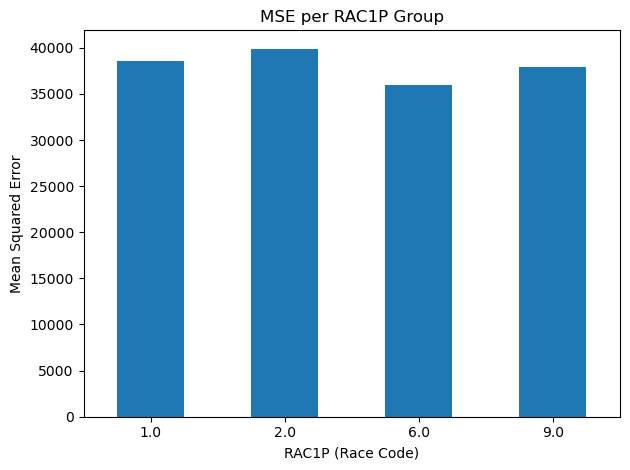

In [ ]:
subgroup_mse.plot(kind='bar', title='MSE per RAC1P Group')
plt.ylabel("Mean Squared Error")
plt.xlabel("RAC1P (Race Code)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## SHAP value analysis between subgroups

In [ ]:
# shap compatibility
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [ ]:
# use TreeSHAP
explainer = shap.TreeExplainer(best_model, X_train)

# SHAP values for test set
shap_values = explainer(X_test)

NameError: name 'best_model' is not defined

In [ ]:
#  base values and shap values
shap_matrix = np.array([sv.values for sv in shap_values])  # shape: [n_samples, n_features]

# put shap values with the original test set
shap_df = pd.DataFrame(shap_matrix, columns=X_test.columns)
shap_df['RAC1P'] = results['RAC1P']
shap_df['SEX'] = results['SEX']
shap_df['true'] = results['true']
shap_df['pred'] = results['pred']
shap_df['correct'] = np.isclose(shap_df['true'], shap_df['pred'], atol=10000)  # example tolerance

KeyboardInterrupt: 

In [ ]:

group = (shap_df['RAC1P'] == 1) 
correct = shap_matrix[group & shap_df['correct']]
incorrect = shap_matrix[group & (~shap_df['correct'])]

# aggregate mean vectors
mean_correct = np.mean(correct, axis=0)
mean_incorrect = np.mean(incorrect, axis=0)

#  distance metrics
cosine_dist = cosine(mean_correct, mean_incorrect)
l2_dist = euclidean(mean_correct, mean_incorrect)

to do: make efficient script to go through all distances

In [ ]:
mean_white = np.mean(shap_matrix[shap_df['RAC1P'] == 1], axis=0)
mean_black = np.mean(shap_matrix[shap_df['RAC1P'] == 2], axis=0)

cosine_dist_group = cosine(mean_white, mean_black)
l2_dist_group = euclidean(mean_white, mean_black)

In [ ]:
mean_white = np.mean(shap_matrix[shap_df['RAC1P'] == 1], axis=0)
mean_asian = np.mean(shap_matrix[shap_df['RAC1P'] == 6], axis=0)

cosine_dist_group = cosine(mean_white, mean_asian)
l2_dist_group = euclidean(mean_white, mean_asian)

In [ ]:
# change? because flattening shap vector means testing all feature contributions
shap_vals_white = shap_matrix[shap_df['RAC1P'] == 1].flatten()
shap_vals_black = shap_matrix[shap_df['RAC1P'] == 2].flatten()

# determine data distribution first
t_stat, t_p = ttest_ind(shap_vals_white, shap_vals_black, equal_var=False)
u_stat, u_p = mannwhitneyu(shap_vals_white, shap_vals_black)

print("T-test p:", t_p)
print("Mann-Whitney U p:", u_p)
